In [18]:
import os
import yaml
import logging
from contextlib import contextmanager, nullcontext

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

In [19]:
print("Setting up logger")
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

mlflow_tracking_uri = 'http://localhost:5555'

Setting up logger


In [20]:
print("Fetching the data")
data_path = '../../data/processed/featured_house_data.csv'

data = pl.read_csv(data_path)
X = data.drop('price')
y = data.select(pl.col('price'))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fetching the data


In [21]:
X.shape, X.columns

((84, 14),
 ['sqft',
  'bedrooms',
  'bathrooms',
  'location_Downtown',
  'location_Mountain',
  'location_Rural',
  'location_Suburb',
  'location_Urban',
  'location_Waterfront',
  'year_built',
  'condition',
  'house_age',
  'price_per_sqft',
  'bed_bath_ratio'])

In [22]:
X

sqft,bedrooms,bathrooms,location_Downtown,location_Mountain,location_Rural,location_Suburb,location_Urban,location_Waterfront,year_built,condition,house_age,price_per_sqft,bed_bath_ratio
i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64
1527,2,1.5,0,0,0,1,0,0,1956,1,70,324.165029,1.333333
2526,3,2.5,1,0,0,0,0,0,1998,3,28,297.70388,1.2
1622,2,1.5,0,0,1,0,0,0,1975,2,51,196.670777,1.333333
3102,4,3.0,0,0,0,0,0,1,2005,3,21,390.070922,1.333333
1835,2,2.0,0,0,0,0,1,0,1982,1,44,251.771117,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2080,3,2.0,0,0,0,0,1,0,1991,1,35,254.807692,1.5
1640,2,1.5,0,0,0,1,0,0,1963,2,63,226.829268,1.333333
2220,3,2.0,1,0,0,0,0,0,1985,1,41,266.666667,1.5


In [23]:
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("House Price Prediction Experiment")

In [24]:
# Define models and hyperparameter grids
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror')
}

model_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [100, 250],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    }
}


In [25]:
print("Doing hyperparameter tuning")

def evaluate_model_with_grid_search(name, model, grid, X_train, X_test, y_train, y_test):
    if grid:
        rf = GridSearchCV(model, grid, cv=3, scoring='r2', n_jobs=-1)
        rf.fit(X_train, y_train)
        best_model = rf.best_estimator_
        best_params = rf.best_params_

    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)


    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model,
        'params': best_params
    }

print("MLFlow tracking URI:", mlflow_tracking_uri)

Doing hyperparameter tuning
MLFlow tracking URI: http://localhost:5555


In [26]:
results = {}

with mlflow.start_run(run_name ="model_comparison") if mlflow_tracking_uri else nullcontext():
    for name, model in models.items():
        logger.info(f"Training model {name}")
        with mlflow.start_run(run_name = name, nested = True) if mlflow_tracking_uri else nullcontext():
            evaluation = evaluate_model_with_grid_search(name, model, model_grids[name], X_train, X_test, y_train, y_test)
            results[name] = evaluation

            if mlflow_tracking_uri:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })
            mlflow.sklearn.log_model(evaluation['model'], artifact_path=name.lower().replace(" ", "_"))

        print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")

INFO:root:Training model LinearRegression
/Users/serinedaouk/Documents/MLOps_projects/house-price-predictor-MLOps/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2026/01/09 06:24:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training model RandomForest


LinearRegression R2: 0.9550, RMSE: 58235.90


/Users/serinedaouk/Documents/MLOps_projects/house-price-predictor-MLOps/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/serinedaouk/Documents/MLOps_projects/house-price-predictor-MLOps/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/serinedaouk/Documents/MLOps_projects/house-price-predictor-MLOps/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example u

RandomForest R2: 0.9656, RMSE: 50934.03


/Users/serinedaouk/Documents/MLOps_projects/house-price-predictor-MLOps/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2026/01/09 06:24:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
INFO:root:Training model XGBoost


GradientBoosting R2: 0.9353, RMSE: 69838.48


/Users/serinedaouk/Documents/MLOps_projects/house-price-predictor-MLOps/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2026/01/09 06:24:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


XGBoost R2: 0.9897, RMSE: 27898.65


In [27]:
results

{'LinearRegression': {'mae': 33487.99860119999,
  'mse': 3391419824.8787923,
  'rmse': 58235.89807737829,
  'r2': 0.9550439565951331,
  'model': LinearRegression(),
  'params': {'copy_X': True,
   'fit_intercept': True,
   'n_jobs': None,
   'positive': False}},
 'RandomForest': {'mae': 27785.098039215693,
  'mse': 2594275241.830067,
  'rmse': 50934.02832910496,
  'r2': 0.9656107599771867,
  'model': RandomForestRegressor(n_estimators=150),
  'params': {'max_depth': None, 'n_estimators': 150}},
 'GradientBoosting': {'mae': 33768.948409181656,
  'mse': 4877413201.164886,
  'rmse': 69838.47937322866,
  'r2': 0.9353458990931988,
  'model': GradientBoostingRegressor(n_estimators=250),
  'params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}},
 'XGBoost': {'mae': 15694.485294117647,
  'mse': 778334745.2714844,
  'rmse': 27898.651316353706,
  'r2': 0.989682536401051,
  'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, c

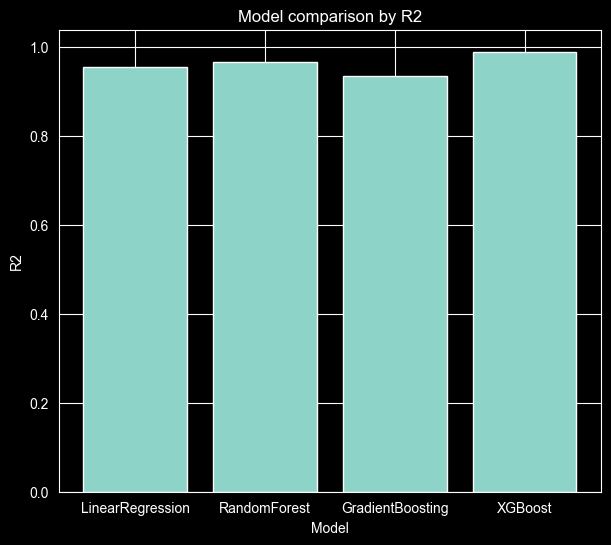

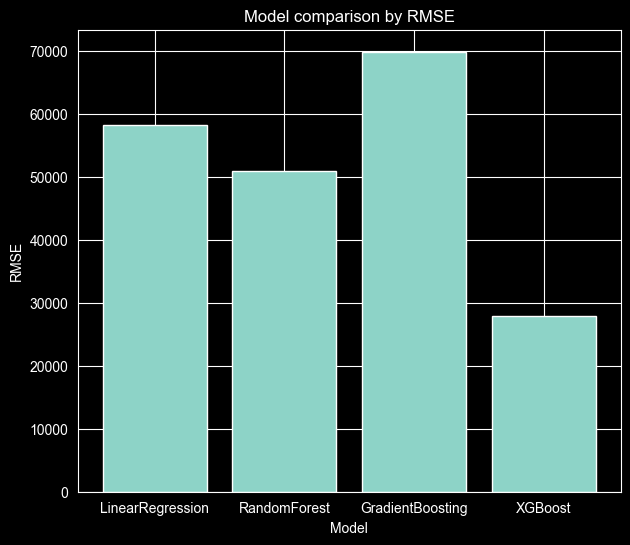

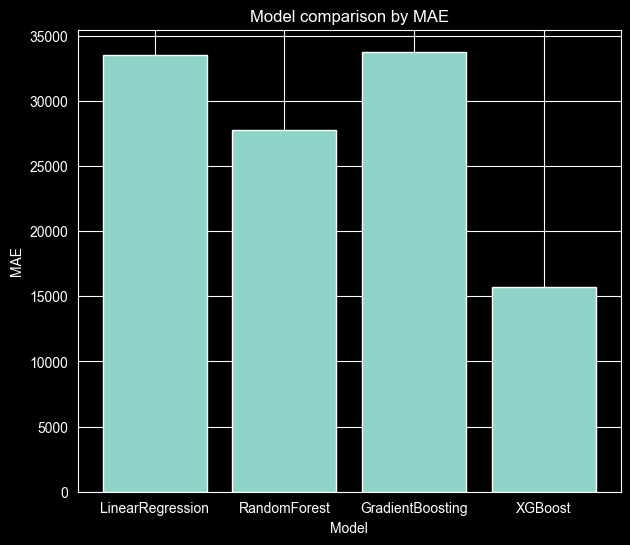

In [29]:
print("Visualizing the difference between models and their metrics")
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(7, 6))
    plt.bar(names, values)
    plt.title(f'Model comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()


plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')

In [30]:
print("Moving metrics configuration to file")

best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_r2 = float(results[best_model_name]['r2'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

model_config = {
    'model': {
        'name': 'house_price_model',
        'best_model': best_model_name,
        'parameters': best_params,
        'r2_score': best_r2,
        'mae': best_mae,
        'target_variable': 'price',
        # 'feature_sets': selected_features_dict
    }
}

Moving metrics configuration to file


In [32]:
config_path = '../../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)

with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"Saved model config to {config_path}")

Saved model config to ../../configs/model_config.yaml
